**Table of contents**<a id='toc0_'></a>    
- [Research And Goal:](#toc1_1_1_)    
      - [Data Source](#toc1_1_1_1_)    
    - [dataset merge function](#toc1_1_2_)    
    - [Combinining Dataset](#toc1_1_3_)    
      - [Create Dataset from Dollar Price Index](#toc1_1_3_1_)    
      - [Replace non-numberic values to NaN](#toc1_1_3_2_)    
      - [show heatmap for NaN values](#toc1_1_3_3_)    
  - [cleaning up dateset](#toc1_2_)    
      - [Drop Rows which value NaN in data](#toc1_2_1_1_)    
      - [Fill NaN](#toc1_2_1_2_)    
    - [Sort and inverse DataFrame](#toc1_2_2_)    
    - [Export Dataset to single CSV File](#toc1_2_3_)    
    - [Plot values](#toc1_2_4_)    
    - [Drop index/periodDateUTC value](#toc1_2_5_)    
    - [check simple correlation between features and Interest Rate](#toc1_2_6_)    
    - [check for correlation between all features](#toc1_2_7_)    
      - [find most correlted feature](#toc1_2_7_1_)    
      - [Variance Inflation Factor (VIF)](#toc1_2_7_2_)    
    - [Feature Selection](#toc1_2_8_)    
      - [Combine Feature which are highly correlated with each other from above figure](#toc1_2_8_1_)    
    - [Spliting data](#toc1_2_9_)    
    - [Bios Calculation](#toc1_2_10_)    
    - [Linear Regression](#toc1_2_11_)    
    - [Multivariate Normality and Homoscedasticity](#toc1_2_12_)    
    - [r2 score and mean squared error](#toc1_2_13_)    
    - [SVR (Support Vector Regression)](#toc1_2_14_)    
    - [Accuracy of SVR](#toc1_2_15_)    
    - [Random Forest Regression:](#toc1_2_16_)    
        - [Accuracy of RFR](#toc1_2_16_1_1_)    
    - [Conclusion](#toc1_2_17_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Research And Goal:](#toc0_)

Understanding the value of the United States Dollar (USD) and its fluctuations is of paramount importance in today's interconnected global economy. The USD's strength or weakness can significantly impact international trade, investments, and overall economic stability. Economic analysts and researchers often employ a range of economic indicators to study and predict the movements of the USD price index, shedding light on the broader economic landscape.

#### <a id='toc1_1_1_1_'></a>[Data Source](#toc0_)

Data Source For Features: <a href ="https://fred.stlouisfed.org">Federal Reserve Bank of St. Louis, One Federal Reserve Bank Plaza, St. Louis</a></br>
Data Source for USD Index: <a href ="https://finance.yahoo.com/quote/DX-Y.NYB/history?period1=31795200&period2=1691884800&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true">Yahoo Finance</a>

In [1117]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### <a id='toc1_1_2_'></a>[dataset merge function](#toc0_)

In [1118]:
def combinedDF(main_df, df, name):

    #rename values of new data
    df.columns.values[1] = name

    if 'DATE' not in main_df.columns: 
        print("Date Doesn't exist.")
        return df.copy()

    # Convert to datetime
    main_df['DATE'] = pd.to_datetime(main_df['DATE'], utc=True)
    df['DATE'] = pd.to_datetime(df['DATE'], utc=True)

    # Calculate time-based features
    main_df['year'] = main_df['DATE'].dt.year
    main_df['month'] = main_df['DATE'].dt.month
    df['year'] = df['DATE'].dt.year
    df['month'] = df['DATE'].dt.month

    # Merge the two dataframes
    merged_df = main_df.merge(df, on=['year', 'month'], how='inner')

    # Assign the 'periodDateUtc_y' values to 'periodDateUtc' column
    merged_df['DATE'] = merged_df['DATE_y']

    # Drop unnecessary columns
    merged_df.drop(columns=['DATE_x', 'DATE_y', 'year', 'month'], inplace=True)

    merged_df.sort_values(by='DATE', inplace=True)
    # Reset the index if needed
    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

### <a id='toc1_1_3_'></a>[Combinining Dataset](#toc0_)

#### <a id='toc1_1_3_1_'></a>[Create Dataset from Dollar Price Index](#toc0_)
<i> Note: It's created Seperately because It's different from all other datasets </i>

In [1119]:
dollar_index = pd.read_csv("./new_data/Price/Dollar Price Index.csv")

data = pd.DataFrame()
data["DATE"] = dollar_index["Date"]
data["Dollar Price Index"] = dollar_index["Close"]

data = pd.DataFrame()
data["DATE"] = dollar_index["Date"]
data["Dollar Price Index"] = dollar_index["Close"]


# Calculate the price change direction (increase or decrease)
data["Change"] = data["Dollar Price Index"].diff()
data["Label"] = data["Change"].apply(lambda x: "Increase" if x > 0 else "Decrease")

NASDAQ_i = pd.read_csv("./new_data/Price/NASDAQ Composite.csv")
NASDAQ = pd.DataFrame()
NASDAQ["DATE"] = NASDAQ_i["Date"]
NASDAQ["NASDAQ"] = NASDAQ_i["Close"]

data = combinedDF(data, NASDAQ, "NASDAQ Composite")

data

,Dollar Price Index,Change,Label,NASDAQ Composite,DATE
0,152.720001,NaN,Decrease,278.700012,1985-01-01 00:00:00+00:00
1,160.410004,7.690003,Increase,284.200012,1985-02-01 00:00:00+00:00
2,149.179993,-11.230011,Decrease,279.200012,1985-03-01 00:00:00+00:00
3,149.699997,0.520004,Increase,280.600006,1985-04-01 00:00:00+00:00
4,147.860001,-1.839996,Decrease,290.799988,1985-05-01 00:00:00+00:00
...,...,...,...,...,...
462,101.860001,-1.050003,Decrease,14346.019531,2023-07-01 00:00:00+00:00
463,102.839996,0.979995,Increase,13644.849609,2023-08-01 00:00:00+00:00
464,102.852997,0.013001,Increase,13644.849609,2023-08-01 00:00:00+00:00
465,102.839996,0.979995,Increase,13644.849609,2023-08-11 00:00:00+00:00


In [1120]:
# Folder containing CSV files
folder_path = './new_data/Features/'

# Get a list of CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Create a dictionary to store DataFrames
dataframes_dict = {}

# Read each CSV file and store it in the dictionary with the filename as key
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes_dict[csv_file] = df

# Print the keys (file names) and the corresponding DataFrames
for filename, df in dataframes_dict.items():
    # print(f"File: {filename}")
    data = combinedDF(data,df,filename.replace('.csv', ''))
    
# data.head(10)

#### <a id='toc1_1_3_2_'></a>[Replace non-numberic values to NaN](#toc0_)

->  get date values since it's non-numberic but it's needed later
anc combine it later

In [1121]:

date_values = data['DATE'].copy()
label_values = data['Label'].copy()


# Apply the function to each element of the DataFrame
data = data.apply(pd.to_numeric, errors='coerce')

data['DATE'] = date_values
data['Label'] = label_values

data.head(20)

,Dollar Price Index,Change,Label,NASDAQ Composite,"All Employees, Total Nonfarm",Consumer Price Index - All Items,Consumer Price Index - Urban Consumers,Federal Funds Effective Rate - Interest Rate,Personal Consumption Expenditures,Personal Income,Personal Saving Rate,Producer Price Index - Total Manufacturing Industries,Producer Price Index by Commodity - All Commodities,Unemployment Rate,University of Michigan - Inflation Expectation,Working Age Population,DATE
0,152.720001,NaN,Decrease,278.700012,96372,44.511575,105.7,8.35,2618.8,3433.9,10.3,NaN,103.4,7.3,2.9,1.505133e+08,1985-01-01 00:00:00+00:00
1,160.410004,7.690003,Increase,284.200012,96503,44.722530,106.3,8.50,2640.8,3452.3,9.1,NaN,103.3,7.2,3.1,1.506300e+08,1985-02-01 00:00:00+00:00
2,149.179993,-11.230011,Decrease,279.200012,96842,44.891295,106.8,8.58,2648.5,3480.0,8.7,NaN,103.1,7.2,3.0,1.507852e+08,1985-03-01 00:00:00+00:00
3,149.699997,0.520004,Increase,280.600006,97038,45.102250,107.0,8.27,2659.5,3478.1,9.9,NaN,103.3,7.3,3.3,1.509430e+08,1985-04-01 00:00:00+00:00
4,147.860001,-1.839996,Decrease,290.799988,97312,45.271014,107.2,7.97,2696.4,3493.4,11.1,NaN,103.5,7.2,3.2,1.510182e+08,1985-05-01 00:00:00+00:00
5,146.119995,-1.740006,Decrease,296.200012,97459,45.397588,107.5,7.53,2689.4,3514.9,9.6,NaN,103.3,7.4,3.4,1.512164e+08,1985-06-01 00:00:00+00:00
6,137.259995,-8.860000,Decrease,301.299988,97648,45.481970,107.7,7.88,2715.7,3528.4,9.1,NaN,103.2,7.4,2.8,1.512276e+08,1985-07-01 00:00:00+00:00
7,138.199997,0.940002,Increase,297.700012,97840,45.566352,107.9,7.90,2752.1,3539.5,8.2,NaN,102.7,7.1,2.8,1.513363e+08,1985-08-01 00:00:00+00:00
8,132.119995,-6.080002,Decrease,280.299988,98045,45.692925,108.1,7.92,2794.7,3561.4,7.3,NaN,102.1,7.1,2.9,1.514698e+08,1985-09-01 00:00:00+00:00
9,129.389999,-2.729996,Decrease,292.500000,98233,45.861689,108.5,7.99,2755.8,3584.0,9.1,NaN,102.9,7.1,3.3,1.516072e+08,1985-10-01 00:00:00+00:00


#### <a id='toc1_1_3_3_'></a>[show heatmap for NaN values](#toc0_)

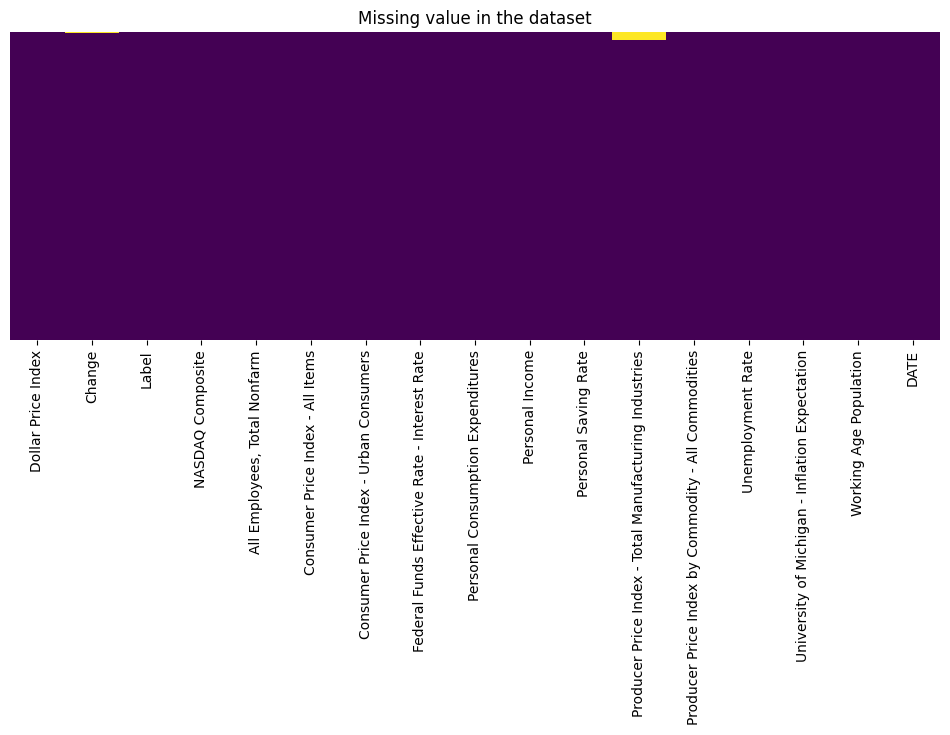

In [1122]:
plt.figure(figsize=(12,4))
sns.heatmap(data.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

## <a id='toc1_2_'></a>[cleaning up dateset](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Drop Rows which value NaN in data](#toc0_)
Nan Dates are not useful because it's doesn't represent anything

In [1123]:
#remove data i fperiodDataUTC is null
data = data.dropna(subset=['DATE']);

#### <a id='toc1_2_1_2_'></a>[Fill NaN](#toc0_)
Fill NaN with previous values if there are any. In case there are not any previous values, we will replace it with zero. </br>

<i>Note: We will not replace non-previous values with avaerage beacause most of the values are in trend line (i.e. incremental) and average doesn't represent the correct value at any given point</i>

In [1124]:
#first fill previous value if there is not a previous value fill 0
for column in data.columns:
    data[column].fillna(method="ffill", inplace=True)
    data[column].fillna(0, inplace=True)
    
data.head(10)

,Dollar Price Index,Change,Label,NASDAQ Composite,"All Employees, Total Nonfarm",Consumer Price Index - All Items,Consumer Price Index - Urban Consumers,Federal Funds Effective Rate - Interest Rate,Personal Consumption Expenditures,Personal Income,Personal Saving Rate,Producer Price Index - Total Manufacturing Industries,Producer Price Index by Commodity - All Commodities,Unemployment Rate,University of Michigan - Inflation Expectation,Working Age Population,DATE
0,152.720001,0.000000,Decrease,278.700012,96372,44.511575,105.7,8.35,2618.8,3433.9,10.3,0.0,103.4,7.3,2.9,1.505133e+08,1985-01-01 00:00:00+00:00
1,160.410004,7.690003,Increase,284.200012,96503,44.722530,106.3,8.50,2640.8,3452.3,9.1,0.0,103.3,7.2,3.1,1.506300e+08,1985-02-01 00:00:00+00:00
2,149.179993,-11.230011,Decrease,279.200012,96842,44.891295,106.8,8.58,2648.5,3480.0,8.7,0.0,103.1,7.2,3.0,1.507852e+08,1985-03-01 00:00:00+00:00
3,149.699997,0.520004,Increase,280.600006,97038,45.102250,107.0,8.27,2659.5,3478.1,9.9,0.0,103.3,7.3,3.3,1.509430e+08,1985-04-01 00:00:00+00:00
4,147.860001,-1.839996,Decrease,290.799988,97312,45.271014,107.2,7.97,2696.4,3493.4,11.1,0.0,103.5,7.2,3.2,1.510182e+08,1985-05-01 00:00:00+00:00
5,146.119995,-1.740006,Decrease,296.200012,97459,45.397588,107.5,7.53,2689.4,3514.9,9.6,0.0,103.3,7.4,3.4,1.512164e+08,1985-06-01 00:00:00+00:00
6,137.259995,-8.860000,Decrease,301.299988,97648,45.481970,107.7,7.88,2715.7,3528.4,9.1,0.0,103.2,7.4,2.8,1.512276e+08,1985-07-01 00:00:00+00:00
7,138.199997,0.940002,Increase,297.700012,97840,45.566352,107.9,7.90,2752.1,3539.5,8.2,0.0,102.7,7.1,2.8,1.513363e+08,1985-08-01 00:00:00+00:00
8,132.119995,-6.080002,Decrease,280.299988,98045,45.692925,108.1,7.92,2794.7,3561.4,7.3,0.0,102.1,7.1,2.9,1.514698e+08,1985-09-01 00:00:00+00:00
9,129.389999,-2.729996,Decrease,292.500000,98233,45.861689,108.5,7.99,2755.8,3584.0,9.1,0.0,102.9,7.1,3.3,1.516072e+08,1985-10-01 00:00:00+00:00


### <a id='toc1_2_2_'></a>[Sort and inverse DataFrame](#toc0_)

Order of ```date``` is most important expect of data, so it's will be sorted by date in decremental order to create modal of old data first.

In [1125]:
# Reverse the order of the DataFrame to make it descending
data = data.iloc[::-1]

# Sort the DataFrame by 'DATE' in ascending order
data.sort_values(by='DATE', inplace=True)

# Reset the index if needed
data.reset_index(drop=True, inplace=True)

# data.head(10)

### <a id='toc1_2_3_'></a>[Export Dataset to single CSV File](#toc0_)

In [1126]:
# Export DataFrame to CSV file
csv_filename = './data.csv'
data.to_csv(csv_filename, index=False)

### <a id='toc1_2_4_'></a>[Plot values](#toc0_)

In [1127]:

# for column in data.columns:
#     plt.plot(data.index, data[column], label=column)

#     # plt.legend()
#     # plt.tight_layout()  # Optional: Adjust the layout for better spacing
#     # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
#     plt.xlabel(column)
#     plt.ylabel('value')
#     plt.title('Line Plot')
#     plt.show()

In [1128]:
# from sklearn.ensemble import IsolationForest


# for column in data.columns:

#     plt.plot(data.index, data[column], c='red', label=column)

#     # Fit the IsolationForest model to detect outliers
#     outlier_detector = IsolationForest(contamination='auto', random_state=42)
#     outlier_detector.fit(data[[column]])

#     # Predict the outliers
#     data['is_outlier'] = outlier_detector.predict(data[[column]])

#     # Update the outlier values with a desired value (e.g., median)
#     median_value = data.loc[data['is_outlier'] == -1, column].median()
#     data.loc[data['is_outlier'] == -1, column] = median_value

#     # Remove the 'is_outlier' column since it's no longer needed
#     data.drop(columns='is_outlier', inplace=True)

#     plt.plot(data.index, data[column], c='blue', label=column+" updated")
#     plt.xlabel('Index')
#     plt.legend()
#     plt.ylabel(column)
#     plt.title(column + ' with Outliers vs Updated')

#     plt.tight_layout()
#     plt.show()


### <a id='toc1_2_5_'></a>[Drop index/periodDateUTC value](#toc0_)

there is no use of date anymore, order is preserved by index and it will create problem for observation since ```DATE``` is non-numeric value

In [1129]:
data = data.drop('DATE', axis=1)

#For regression
data = data.drop('Change', axis=1)
data = data.drop('Label', axis=1)

### <a id='toc1_2_6_'></a>[check simple correlation between features and Interest Rate](#toc0_)

The correlation coefficient ranges from -1 to 1:</br></br>

If the correlation coefficient is close to 1, it indicates a strong positive correlation, meaning that as one variable increases, the other tends to increase as well. </br>
If the correlation coefficient is close to -1, it indicates a strong negative correlation, meaning that as one variable increases, the other tends to decrease. </br>
If the correlation coefficient is close to 0, it indicates a weak or no linear correlation between the two variables.</br>

In [1130]:
# for column in data.columns:
#     correlation = data[column].corr(data['Dollar Price Index'])

#     # Plot a scatter plot to visualize the correlation
#     plt.scatter(data[column], data['Dollar Price Index'])
#     plt.xlabel(column)
#     plt.ylabel('Dollar Price Index')
#     plt.title(f'Correlation: {correlation:.2f}')
#     plt.grid(True)
#     plt.show()

### <a id='toc1_2_7_'></a>[check for correlation between all features](#toc0_)

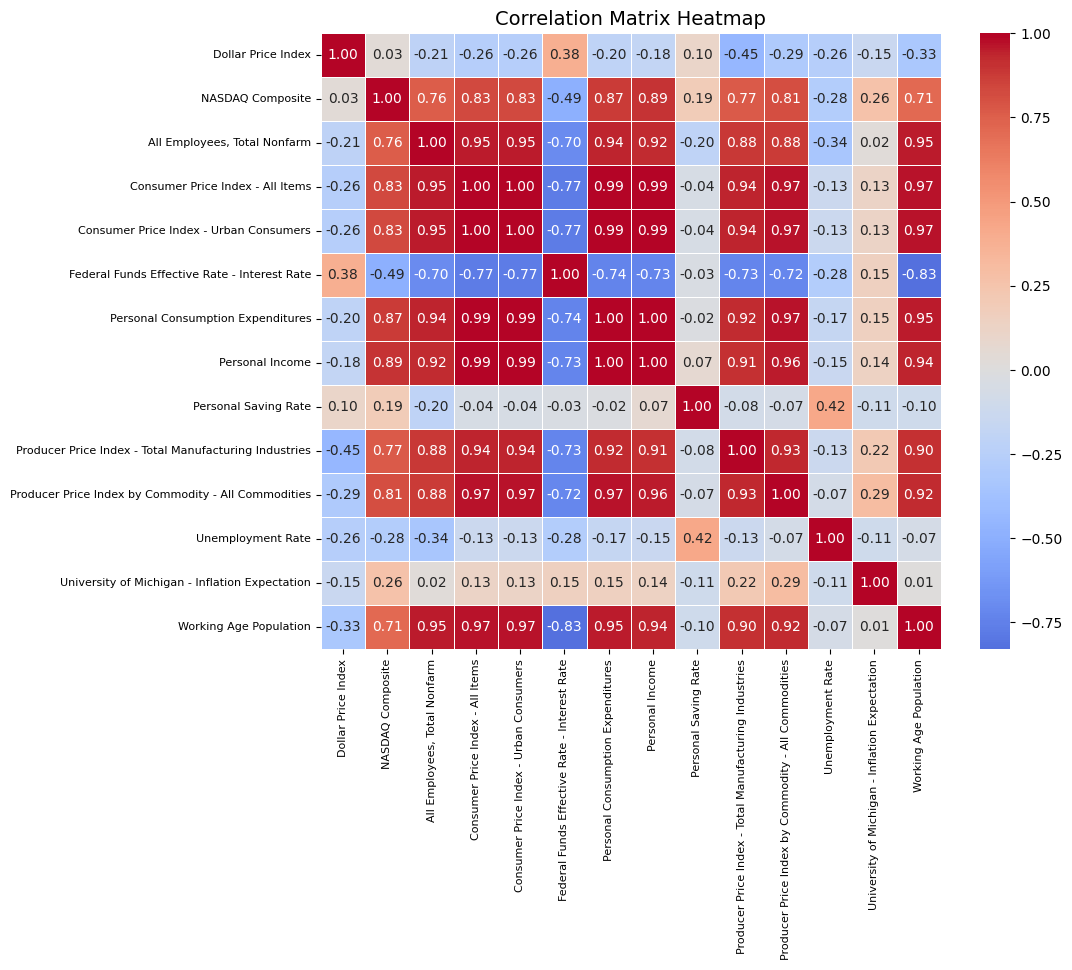

In [1131]:
numeric_df = data.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))

ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5,
                 annot_kws={"size": 10})

# Adjust the font size of x-axis and y-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.show()

#### <a id='toc1_2_7_1_'></a>[find most correlted feature](#toc0_)

In [1132]:
def getMulticollinearFeatures(df, threshold): 
    numeric_df = df.select_dtypes(include='number')
    correlation_matrix = numeric_df.corr()

    # Select highly correlated features
    multicollinear_features = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                multicollinear_features.append(colname_i)
                multicollinear_features.append(colname_j)

    return multicollinear_features;

In [1133]:
def plotMulticollinearFeatures(features):
    multicollinear_features = np.array(features)
    string_counts = Counter(multicollinear_features)

    sorted_string_counts = dict(sorted(string_counts.items(), key=lambda x: x[1], reverse=False))
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_string_counts.keys(), sorted_string_counts.values())
    plt.xlabel('multicollinear features')
    plt.ylabel('Frequency')
    plt.title('Distribution of Strings by Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### <a id='toc1_2_7_2_'></a>[Variance Inflation Factor (VIF)](#toc0_)

<p>The Variance Inflation Factor (VIF) is a measure used to detect multicollinearity in a regression analysis. It quantifies how much the variance of the estimated regression coefficient is increased due to multicollinearity. High VIF values indicate high multicollinearity between predictor variables, which can affect the stability and interpretability of regression models.</p>

<p>VIF is a metric that quantifies the extent of multicollinearity in a feature by measuring how much the variance of an estimated regression coefficient increases when that feature is added to the model. </br>
High VIF values (>5 or 10) suggest the presence of multicollinearity.</P>

In [1134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def getVIF(df): 
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    numeric_df = df.select_dtypes(include='number')
    vif['Feature'] = numeric_df.columns
    vif['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

    print(vif)

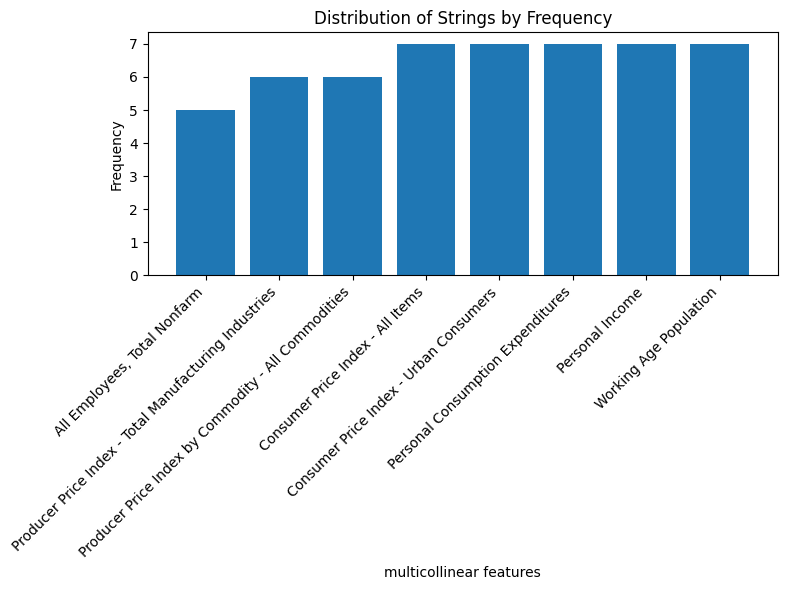

In [1135]:
features = getMulticollinearFeatures(data, 0.9)
plotMulticollinearFeatures(features)


### <a id='toc1_2_8_'></a>[Feature Selection](#toc0_)

#### <a id='toc1_2_8_1_'></a>[Combine Feature which are highly correlated with each other from above figure](#toc0_)

['Consumer Price Index - All Items', 'Consumer Price Index - Urban Consumers']
['Producer Price Index - Total Manufacturing Industries', 'Producer Price Index by Commodity - All Commodities']


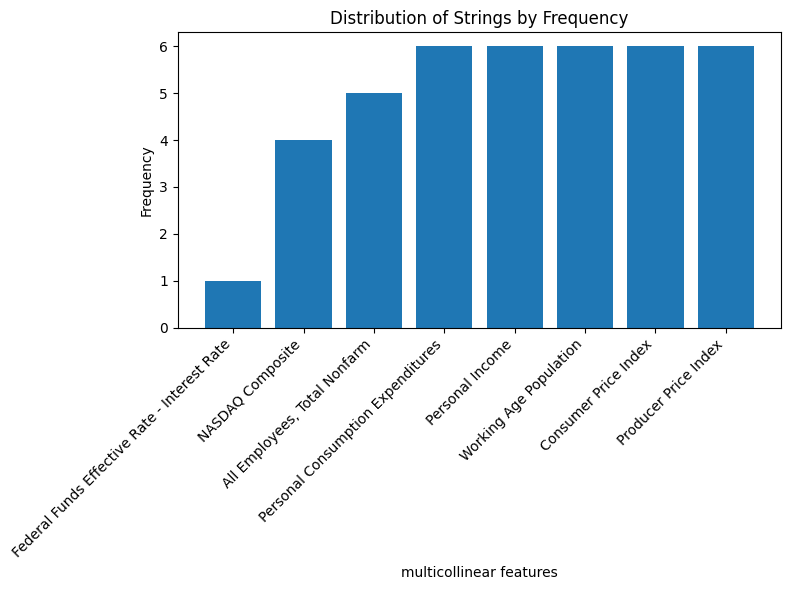

In [1136]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Standardize the data (mandatory for PCA)
scaler = StandardScaler()

# Apply PCA to reduce the dimensionality to 1 component
pca_cols = {
    'Consumer Price Index': ["Consumer Price Index - All Items", "Consumer Price Index - Urban Consumers"],
    'Producer Price Index': ["Producer Price Index - Total Manufacturing Industries", "Producer Price Index by Commodity - All Commodities"],
    
}

for name, cols in pca_cols.items():
    print(cols)
    X_std = scaler.fit_transform(data[cols])

    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X_std)

    data[name] = X_pca
    data = data.drop(cols, axis=1)  # Independet variable

features = getMulticollinearFeatures(data, 0.8)
plotMulticollinearFeatures(features)

In [1137]:
getVIF(data);

                                           Feature           VIF
0                               Dollar Price Index    146.439726
1                                 NASDAQ Composite     49.614950
2                     All Employees, Total Nonfarm   8686.643481
3     Federal Funds Effective Rate - Interest Rate     15.714976
4                Personal Consumption Expenditures   4915.943194
5                                  Personal Income   6780.790391
6                             Personal Saving Rate     91.664992
7                                Unemployment Rate    140.724655
8   University of Michigan - Inflation Expectation     49.600555
9                           Working Age Population  16014.243022
10                            Consumer Price Index    277.167810
11                            Producer Price Index     41.355559


In [1138]:
print(data.describe())

       Dollar Price Index  NASDAQ Composite  All Employees, Total Nonfarm  \
count          462.000000        462.000000                    462.000000   
mean            93.825173       3261.476736                 128233.696970   
std             12.801908       3480.706045                  15359.096666   
min             71.800003        278.700012                  96372.000000   
25%             85.270002        768.414993                 114987.750000   
50%             93.049999       2112.260009                 131129.500000   
75%             98.859999       4161.082398                 138064.500000   
max            160.410004      15644.969727                 156155.000000   

       Federal Funds Effective Rate - Interest Rate  \
count                                     462.00000   
mean                                        3.37658   
std                                         2.78654   
min                                         0.05000   
25%                            

### <a id='toc1_2_9_'></a>[Spliting data](#toc0_)

In [1139]:
from sklearn.model_selection import train_test_split
target = 'Dollar Price Index'
# target = 'Federal Funds Effective Rate - Interest Rate'
test_size = 0.2
metrics = {'R-squared': {}, 'Mean Squared Error': {}, 'Residual Mean': {}, 'Predictions': {}}

X = data.drop(target,axis=1) # Independet variable
y = data[target] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=23)

### <a id='toc1_2_10_'></a>[Bios Calculation](#toc0_)

In [1140]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [1141]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

This process essentially calculates the coefficients (parameters) for each feature, including the bias term, in the linear regression model. The resulting DataFrame parameter_df provides a clear representation of the model's parameters and their relationship with the features.

### <a id='toc1_2_11_'></a>[Linear Regression](#toc0_)

In [1142]:
# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,249.394833,249.394833
1,theta_1,NASDAQ Composite,-0.002937,-0.002937
2,theta_2,"All Employees, Total Nonfarm",0.000601,0.000601
3,theta_3,Federal Funds Effective Rate - Interest Rate,-0.634245,-0.634245
4,theta_4,Personal Consumption Expenditures,-0.003018,-0.003018
5,theta_5,Personal Income,0.016214,0.016214
6,theta_6,Personal Saving Rate,-3.070709,-3.070709
7,theta_7,Unemployment Rate,2.228338,2.228338
8,theta_8,University of Michigan - Inflation Expectation,0.043042,0.043042
9,theta_9,Working Age Population,-0.000002,-0.000002


In [1143]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  57.17670769344698
R square obtain for normal equation method is : 0.43465315121019854


In [1144]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  57.17670769493619
R square obtain for scikit learn library is : 0.43465315119547365


C:\Users\ACER\AppData\Local\Temp\ipykernel_14288\2482664790.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_pred_sk),ax=ax,color='b')


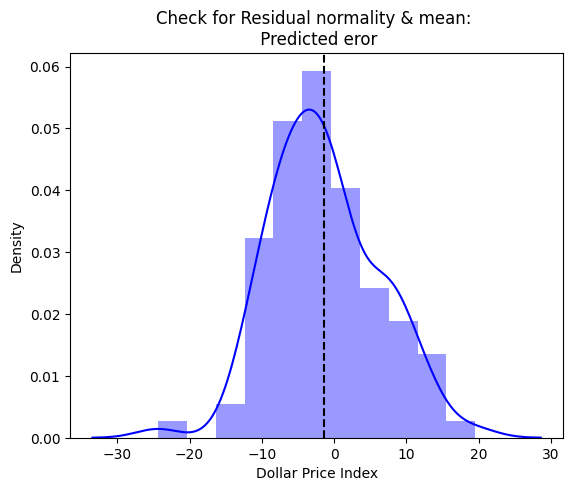

In [1145]:
# Check for Linearity
f = plt.figure(figsize=(14,5))

# sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
# sns.scatterplot(x=y_test,y=y_pred_sk, color='r')
# sns.scatterplot(data = ax, color='b')


# ax.set_title('Check for Linearity:\n Unemployed Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Predicted eror');

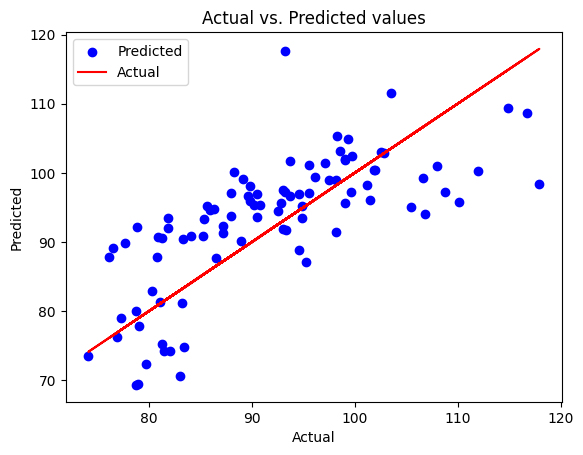

In [1146]:
# Plot actual vs. predicted values in different colors
plt.scatter(y_test, y_pred_sk, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

### <a id='toc1_2_12_'></a>[Multivariate Normality and Homoscedasticity](#toc0_)

In [1147]:
# # Check for Multivariate Normality
# # Quantile-Quantile plot 
# plt.figure(figsize=(8, 6))
# _,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=plt)
# plt.title('Check for Multivariate Normality: Q-Q Plot')
# plt.legend().set_visible(False)  # Hide the legend
# plt.show()

# # Calculate the residuals
# residuals = y_test - y_pred_sk

# # Create the plot with different colors for actual and predicted values
# plt.figure(figsize=(8, 6))
# sns.scatterplot(y=residuals, x=y_pred_sk, hue=residuals, palette='coolwarm', alpha=0.7)
# plt.axhline(0, color='gray', linestyle='dashed')  # Add a dashed line at y=0 for reference
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals (Actual - Predicted)')
# plt.title('Homoscedasticity: Original Vs. Predicted: (Residuals Plot)')
# plt.legend()
# plt.show()

In [1148]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- R_square_sk)

### <a id='toc1_2_13_'></a>[r2 score and mean squared error](#toc0_)

The Mean Squared Error (MSE) indicates the average squared difference between the predicted values and the actual values in your regression model. A lower MSE value indicates better model performance, as it means the model's predictions are closer to the actual values.

The formula for calculating MSE is:

�
�
�
=
1
�
∑
�
=
1
�
(
�
�
−
�
^
�
)
2
MSE= 
n
1
​
 ∑ 
i=1
n
​
 (y 
i
​
 − 
y
^
​
  
i
​
 ) 
2
 

Where:

�
n is the number of samples in the test set.
�
�
y 
i
​
  is the actual value for the 
�
ith sample.
�
^
�
y
^
​
  
i
​
  is the predicted value for the 
�
ith sample.

In [1149]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_sk)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, y_pred_sk)
print("Root Squared Error:", r2)

residuals = 100 - abs((y_test - y_pred_sk) * 100/ y_test)

residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

print("Mean of Residuals / Accouracy :", residual_mean)


metrics['R-squared']['Linear Regression'] = r2
metrics['Mean Squared Error']['Linear Regression'] = mse
metrics['Residual Mean']['Linear Regression'] = residual_mean
metrics['Predictions']['Linear Regression'] = y_pred_sk

Mean Squared Error: 57.17670769493619
Root Squared Error: 0.43465315119547365
Mean of Residuals / Accouracy : 93.21554863919881


### <a id='toc1_2_14_'></a>[SVR (Support Vector Regression)](#toc0_)

In [1150]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [1151]:
X = data.drop(target,axis=1) # Independet variable
y = data[target] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=23)

# Standardize the features (optional but can improve model performance)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVR model
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_scaled)

### <a id='toc1_2_15_'></a>[Accuracy of SVR](#toc0_)

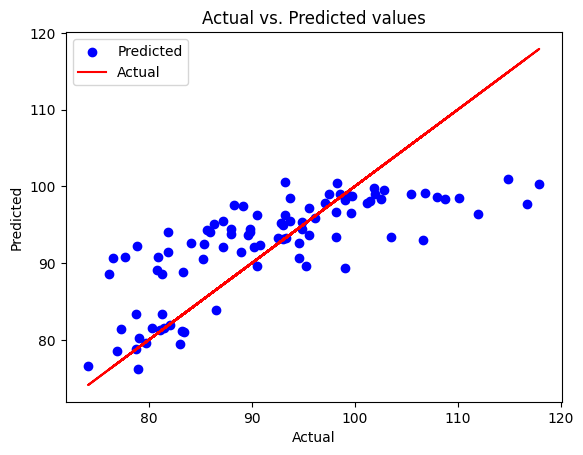

In [1152]:
# Plot actual vs. predicted values in different colors
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

In [1153]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, y_pred)
print("Root Squared Error:", r2)

residuals = 100 - abs((y_test - y_pred) * 100/ y_test)
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)


metrics['R-squared']['SVR'] = r2
metrics['Mean Squared Error']['SVR'] = mse
metrics['Residual Mean']['SVR'] = residual_mean
metrics['Predictions']['SVR'] = y_pred

Mean Squared Error: 45.962433344007366
Root Squared Error: 0.5455366721521818


### <a id='toc1_2_16_'></a>[Random Forest Regression:](#toc0_)

In [1154]:
from sklearn.ensemble import RandomForestRegressor

X = data.drop(target,axis=1) # Independet variable
y = data[target] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=23)

# Create a Random Forest Regressor model
# We'll use 10 decision trees in the ensemble
model = RandomForestRegressor(n_estimators=100, random_state=23)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = model.predict(X_test)

##### <a id='toc1_2_16_1_1_'></a>[Accuracy of RFR](#toc0_)

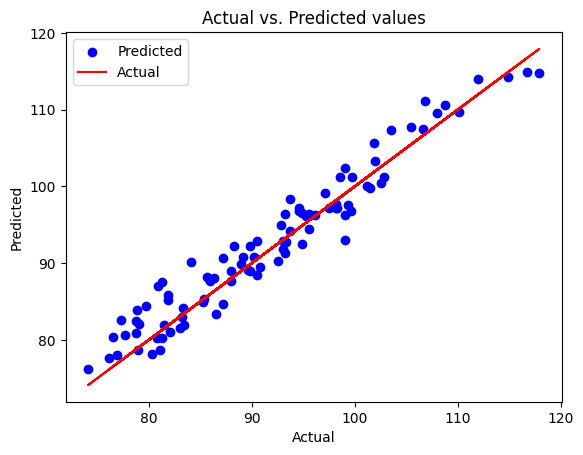

In [1155]:
# Plot actual vs. predicted values in different colors
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot(y_test, y_test, color='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

In [1156]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, y_pred)
print("Root Squared Error:", r2)

residuals = 100 - abs((y_test - y_pred) * 100/ y_test)

residual_mean = np.mean(residuals)
residual_std = np.std(residuals)


metrics['R-squared']['Random Forest Regression'] = r2
metrics['Mean Squared Error']['Random Forest Regression'] = mse
metrics['Residual Mean']['Random Forest Regression'] = residual_mean
metrics['Predictions']['Random Forest Regression'] = y_pred


Mean Squared Error: 6.604885210946148
Root Squared Error: 0.9346927937745753


### <a id='toc1_2_17_'></a>[Conclusion](#toc0_)

compairing values of all 3 algorithms

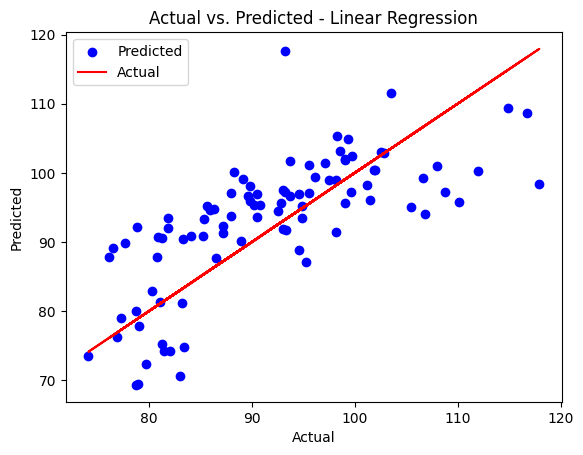

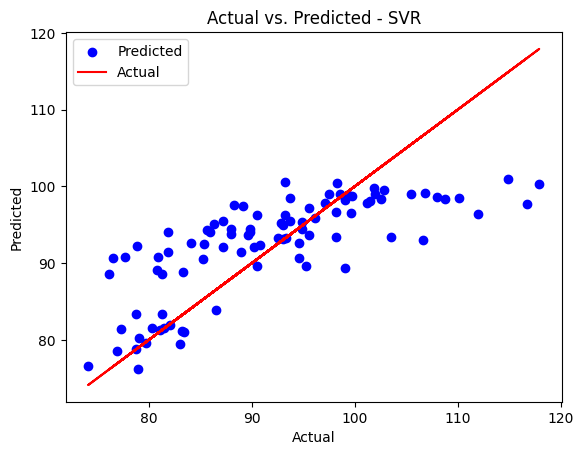

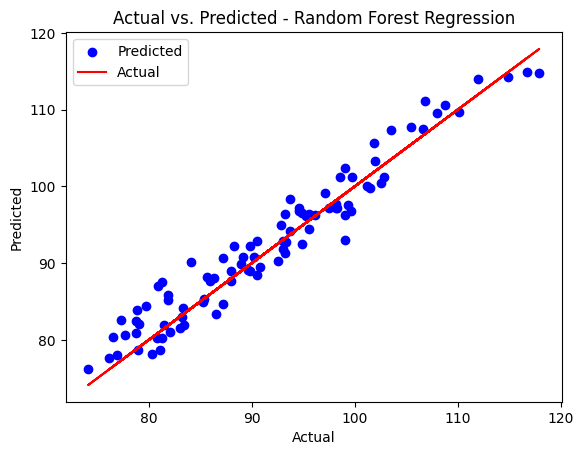

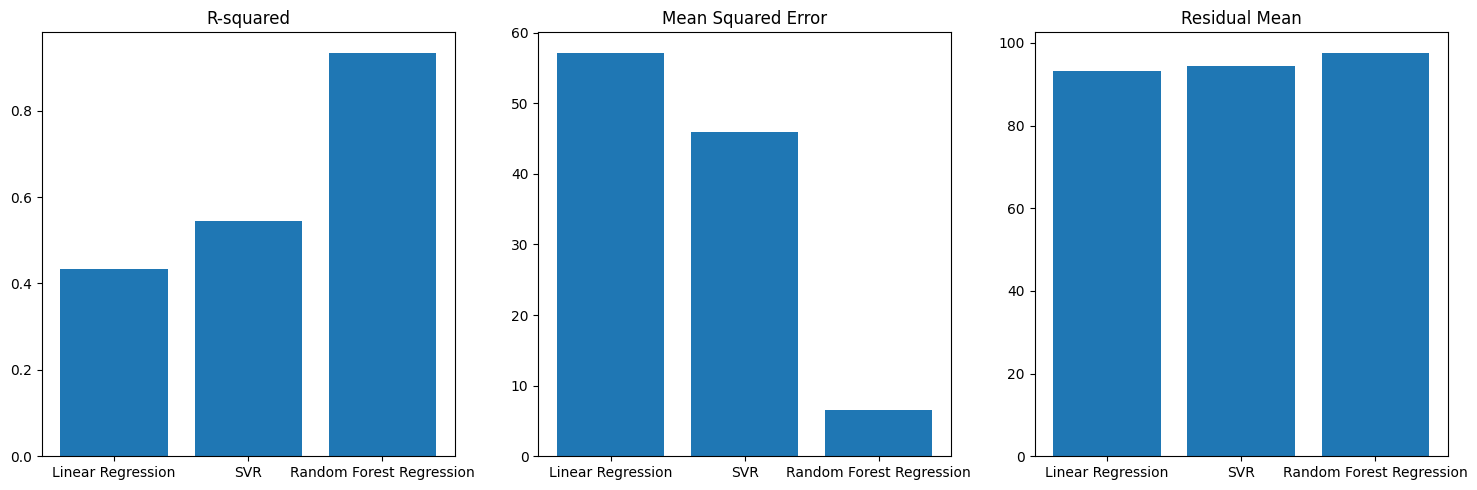

In [1157]:
# Print the results
for metric_name, metric_values in metrics.items():
    model_name = metric_name
    for model_name, value in metric_values.items():
        if metric_name == 'Predictions':
            # Plot actual vs. predicted values in different colors
            plt.scatter(y_test, value, color='blue', label='Predicted')
            plt.plot(y_test, y_test, color='red', label='Actual')
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title("Actual vs. Predicted - " + model_name)
            plt.legend()
            plt.show()


# Extract metric values for each model
model_names = list(metrics['R-squared'].keys())
r2_scores = list(metrics['R-squared'].values())
mse_scores = list(metrics['Mean Squared Error'].values())
residual_means = list(metrics['Residual Mean'].values())

# Create bar plots for the evaluation metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(model_names, r2_scores)
plt.title('R-squared')

plt.subplot(1, 3, 2)
plt.bar(model_names, mse_scores)
plt.title('Mean Squared Error')

plt.subplot(1, 3, 3)
plt.bar(model_names, residual_means)
plt.title('Residual Mean')

plt.tight_layout()
plt.show()

In [1158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [1159]:
data = pd.read_csv("./data.csv")

data  = data.drop('DATE', axis=1)

In [1160]:
X = data.drop('Label', axis=1) 
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1161]:
# Store the accuracy scores and model names in lists
accuracy_scores = []
model_names = []

In [1162]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [1163]:
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)

In [1164]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix_logreg = confusion_matrix(y_test, y_pred)

accuracy_scores.append(accuracy_score(y_test, y_pred_logreg))
model_names.append("Logistic Regression")

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.967741935483871
Confusion Matrix:
 [[51  2]
 [ 0 40]]


Logistic Regression Accuracy: 0.978494623655914
Logistic Regression Confusion Matrix:
 [[51  2]
 [ 0 40]]
Decision Tree Accuracy: 1.0
Decision Tree Confusion Matrix:
 [[53  0]
 [ 0 40]]
Random Forest Accuracy: 1.0
Random Forest Confusion Matrix:
 [[53  0]
 [ 0 40]]
Support Vector Machine Accuracy: 0.9354838709677419
Support Vector Machine Confusion Matrix:
 [[48  5]
 [ 1 39]]


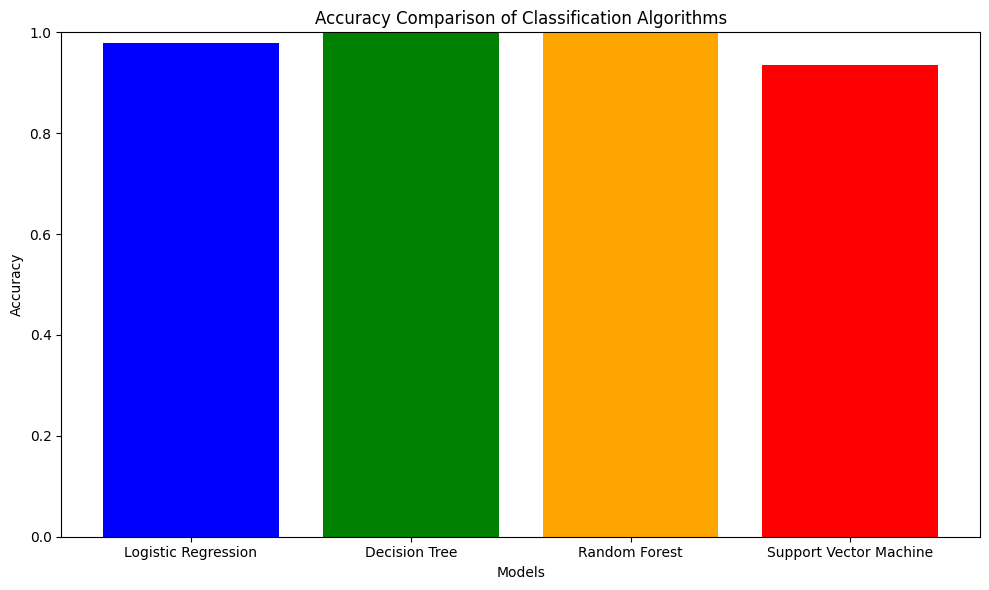

In [1165]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create and train the Decision Tree model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_std, y_train)
y_pred_dt = decision_tree.predict(X_test_std)

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
accuracy_scores.append(accuracy_score(y_test, y_pred_dt))
model_names.append("Decision Tree")

# Create and train the Random Forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train_std, y_train)
y_pred_rf = random_forest.predict(X_test_std)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_scores.append(accuracy_score(y_test, y_pred_rf))
model_names.append("Random Forest")

# Create and train the Support Vector Machine (SVM) model
svm = SVC()
svm.fit(X_train_std, y_train)
y_pred_svm = svm.predict(X_test_std)

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
accuracy_scores.append(accuracy_score(y_test, y_pred_svm))
model_names.append("Support Vector Machine")
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} Confusion Matrix:\n", conf_matrix)

evaluate_model(y_test, y_pred_logreg, "Logistic Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_svm, "Support Vector Machine")

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Classification Algorithms")
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.tight_layout()

# Show the plot
plt.show()

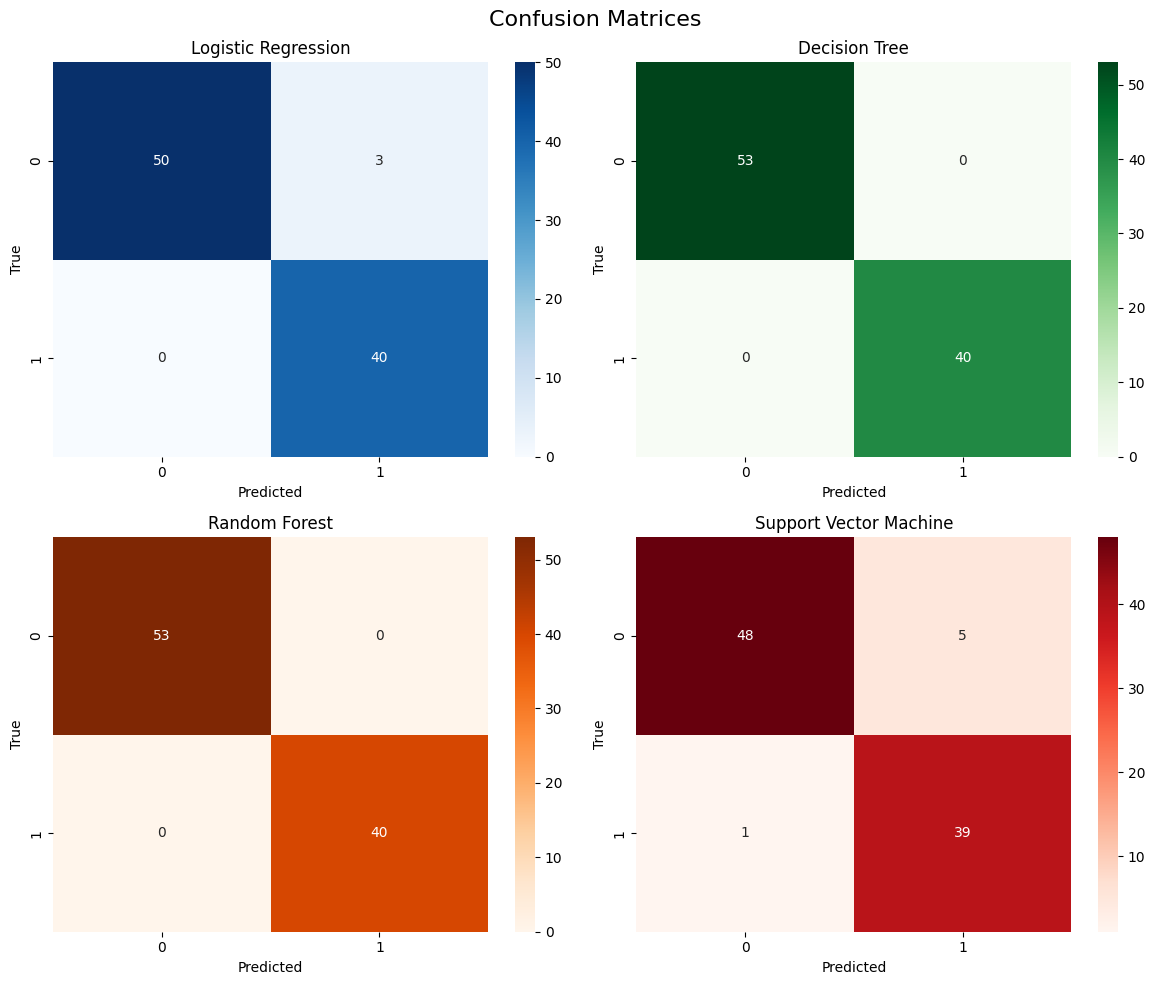

In [1166]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Confusion Matrices", fontsize=16)

# Plot Confusion Matrix for Logistic Regression
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Logistic Regression")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

# Plot Confusion Matrix for Decision Tree
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Greens", ax=axes[0, 1])
axes[0, 1].set_title("Decision Tree")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

# Plot Confusion Matrix for Random Forest
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Oranges", ax=axes[1, 0])
axes[1, 0].set_title("Random Forest")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

# Plot Confusion Matrix for Support Vector Machine
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Reds", ax=axes[1, 1])
axes[1, 1].set_title("Support Vector Machine")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

plt.tight_layout()
plt.show()